# TimeGAN Sythetic Data Backtesting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.saving import load_model

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

2024-04-24 20:13:05.024442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 20:13:05.024502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 20:13:05.024509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 20:13:05.030227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
experiment = 0

In [5]:
path = Path('time_gan_research_variable')
hdf_store = path / 'TimeSeriesGAN.h5'
results_path = Path('time_gan_research_variable')
log_dir = results_path / f'experiment_{experiment:02}'

# Parameters

In [6]:
seq_len = 24 #window of time (days) that model uses to predict last (24th) day
n_seq = 30 #ticker count
batch_size = 128

start_date, end_date = '2000-01-01', '2022-12-01' #ticker price data yyyy-mm-dd
train_test_split = 0.8

In [7]:
scaler = MinMaxScaler()

In [8]:
#Pulled manually from
#https://money.cnn.com/magazines/fortune/fortune500_archive/full/2000/
tickers = ['ALL', 'WMT', 'XOM', 'F', 'GE', 'IBM', 'C', 'T', 'MO', 'BA', 
           'BAC', 'HPQ', 'KR', 'STFGX', 'AIG', 'HD', 'PG', 'FNMA', 'CVX', 
           'MS', 'JPM', 'TGT', 'VZ', 'MRK', 'MSI', 'MCK', 'INTC', 'DD', 'JNJ', 'COST']

# Real Data Prep

In [9]:
def get_real_data():
    df = yf.download(tickers, start_date, end_date)['Adj Close']
    # Preprocess the dataset:
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data, df, df.index


real_data, yf_df, yf_index = get_real_data()


[*********************100%%**********************]  30 of 30 completed


In [10]:
n_windows = len(real_data)

# Sythetic Data Prep

In [11]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [12]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

2024-04-24 20:13:12.198814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38386 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [13]:
synthetic_data_keras = load_model(log_dir / "synthetic_data.keras")

In [14]:
print(synthetic_data_keras.summary())

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 30)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11832     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 30)            11550     
                                                                 
Total params: 31182 (121.80 KB)
Trainable params: 31182 (121.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
#every time this is called, a new sythetic series is generated
def generate_data():
    generated_data = []
    for i in range(int(n_windows / batch_size)):
        Z_ = next(random_series)
        d = synthetic_data_keras(Z_)
        generated_data.append(d)
    generated_data = np.array(np.vstack(generated_data))
    #generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
    return generated_data

# Models

In [16]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)),
                        Dense(30)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [17]:
#synthetic_data = generate_data()
#len(synthetic_data)

In [18]:
#Set indecies for train/test splits
real_data = np.array(real_data)[:5632] #Length of sythetic data

n_series = real_data.shape[0]

idx = np.arange(n_series)

n_train = int(train_test_split*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [19]:
real_test_data = real_data[test_idx, :seq_len-1, :]
real_test_label = real_data[test_idx, -1, :]

In [20]:
def model_predictions(data, train_idx):
    data_train = data[train_idx, :seq_len-1, :]
    data_label = data[train_idx, -1, :]

    ts_regression = get_model()
    synthetic_result = ts_regression.fit(x=data_train,
                                        y=data_label,
                                        validation_data=(
                                            real_test_data, 
                                            real_test_label),
                                        epochs=100,
                                        batch_size=batch_size,
                                        verbose=0)
    test_predict_scaled = ts_regression.predict(real_test_data, verbose=0)
    test_predict = pd.DataFrame(scaler.inverse_transform(test_predict_scaled).squeeze())
    return test_predict

In [21]:
#test_predict = model_predictions(real_data, train_idx)

In [22]:
#Reverse real data back from scaler
real_unscaled = pd.DataFrame(scaler.inverse_transform(real_test_label).squeeze())

In [23]:
#Set index to dates
real_unscaled = real_unscaled.set_index(yf_index[test_idx])
#test_predict = test_predict.set_index(yf_index[test_idx])

In [24]:
def plot_preformance(real, predict, filename):
    ticker_count = len(tickers)
    fig, axes = plt.subplots(nrows=ticker_count//2, ncols=2, 
                             figsize=(int(ticker_count*14/6), int(ticker_count*7/6)))
    axes = axes.flatten()

    for j, ticker in enumerate(tickers):
        (pd.DataFrame({'Real': real.iloc[:, j],
                    'Synthetic Trained': predict.iloc[:, j]})
        .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
    sns.despine()
    fig.tight_layout()
    fig.savefig(filename)

#plot_preformance(real_unscaled, test_predict)

# Backtesting

In [25]:
#To Get our Backtestingpy strategy to work nice with different tickers
#We have to create a new class for each ticker
def ModelStrategy(ticker_series):
    class ModelStrategy_Inst(Strategy):
        percent_to_beat = 0.05

        def init(self):
            self.predict_iter = iter(ticker_series.to_numpy())
            self.price_today = next(self.predict_iter)

        def next(self):
            price_tomorrow = next(self.predict_iter)
            if price_tomorrow > self.price_today+self.price_today*self.percent_to_beat:
                self.buy()
            elif price_tomorrow < self.price_today-self.price_today*self.percent_to_beat:
                self.sell()
            self.price_today = price_tomorrow
    return ModelStrategy_Inst

In [26]:
#Backtesting On Each Stock 
def backtest(prediction):
    return_percents = [0]*len(tickers)
    stats_dict = {}
    bt_dict = {}
    for idx in range(len(tickers)):
        #YF redownload all values as needed by backtesting
        price_df = yf.download(tickers[idx], prediction.index[0], prediction.index[-1])
        #Initiate and optimize backtest based on best percent_to_beat value
        bt = Backtest(price_df, ModelStrategy(prediction[idx]), commission=0.002, exclusive_orders=True)
        stats_opt = bt.run()
        return_percents[idx] = stats_opt["Return [%]"]
        stats_dict.update({tickers[idx]: stats_opt})
        bt_dict.update({tickers[idx]: bt})
    return return_percents, stats_dict, bt_dict

#return_percents, stats_dict, bt_dict = backtest(test_predict)


# Real Looping

In [27]:
iterations = 15

In [29]:
best_real_model = None
best_real_return_avg = 0
best_real_test_predict = None
for k in range(iterations):
    print("Iteration: "+str(k))

    test_predict = model_predictions(real_data, train_idx)
    test_predict = test_predict.set_index(yf_index[test_idx])

    return_percents, stats_dict, bt_dict = backtest(test_predict)
    return_avg = np.average(return_percents)

    if best_real_model==None or best_real_return_avg<return_avg:
        best_real_model = return_percents, stats_dict, bt_dict
        best_real_return_avg = return_avg
        best_real_test_predict = test_predict
        print("New Best With Returns: "+str(best_real_model[0]))

Iteration: 0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-92.62940458511359, 3.9799577616882202, -100.0, -11.60518603683473, -100.0, -6.71176357543949, -27.65391821258543, -17.315135388450635, -53.189780977859556, -94.99137117202774, -100.0, 69.86688591537474, 15.674376623535155, 2.571535987396237, -100.0, -22.482982933654775, -38.13859504211424, -76.3295950252819, 0.0, 86.23088149696355, 0.0, -100.0, 15.929815004577613, 20.748097285156273, 11.071211682434095, 109.57811119445805, 5.432617710113518, -24.680719137115467, -19.127006370849614, 44.599389999999985]
Iteration: 1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-86.30351486846943, -3.7895304591369494, -100.0, 52.561694878339715, 68.99634215797447, -24.900107058105494, -18.10462189376833, -14.457597735290456, -29.22647689659119, -87.65113187713635, 23.713952055129994, -100.0, -71.95172838634488, -34.872152467803964, -100.0, -24.988476236877432, -39.448670010528566, 411.1451581390357, 141.26182257247925, -100.0, 2.9330580177307457, -100.0, -23.1628521273804, 19.733699518737794, -100.0, 102.8164824597168, -29.692762335968027, 38.56824570037843, 23.58496201538086, 61.258165560913056]
Iteration: 2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-68.05851351730361, 11.623175863418583, 115.63819254043575, 78.94286663912776, -14.401062407226709, 7.208225115966779, -26.627252190399158, -20.021293095626824, -11.984247823638853, -86.6722190959169, -14.646333522529604, 72.79862827106473, 9.264608230171216, -39.052554066772444, -100.0, 22.324733039855964, -39.58219283447264, 0.0, -64.18317239166258, 92.6132181905365, 2.800265344848631, -41.08791513214115, 6.978406781158466, -13.171571300964352, 11.225457615356463, 103.60618509613036, 60.050105954437264, 0.0, 17.72406403320312, -42.806387955322265]
Iteration: 6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [4.569937135162218, -10.873831140441888, -52.13874889114381, 295.76882722420686, 201.07602348575594, 7.808523663330052, 35.51826827346802, -28.52063627658846, -4.322966069488502, -47.240970807037485, 75.30566537612921, 71.80938691368101, -72.29793982566835, 12.84898604507447, 51.80768883842467, -21.677199950256345, -39.39034923736573, 0.0, 0.0, 43.51571213890078, 12.012099455566403, -100.0, -16.949094667129522, 15.736072491912855, 14.986801836242686, 0.0, -16.138708742446905, -26.10085989257812, -17.45547897491455, 40.30546807189938]
Iteration: 8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

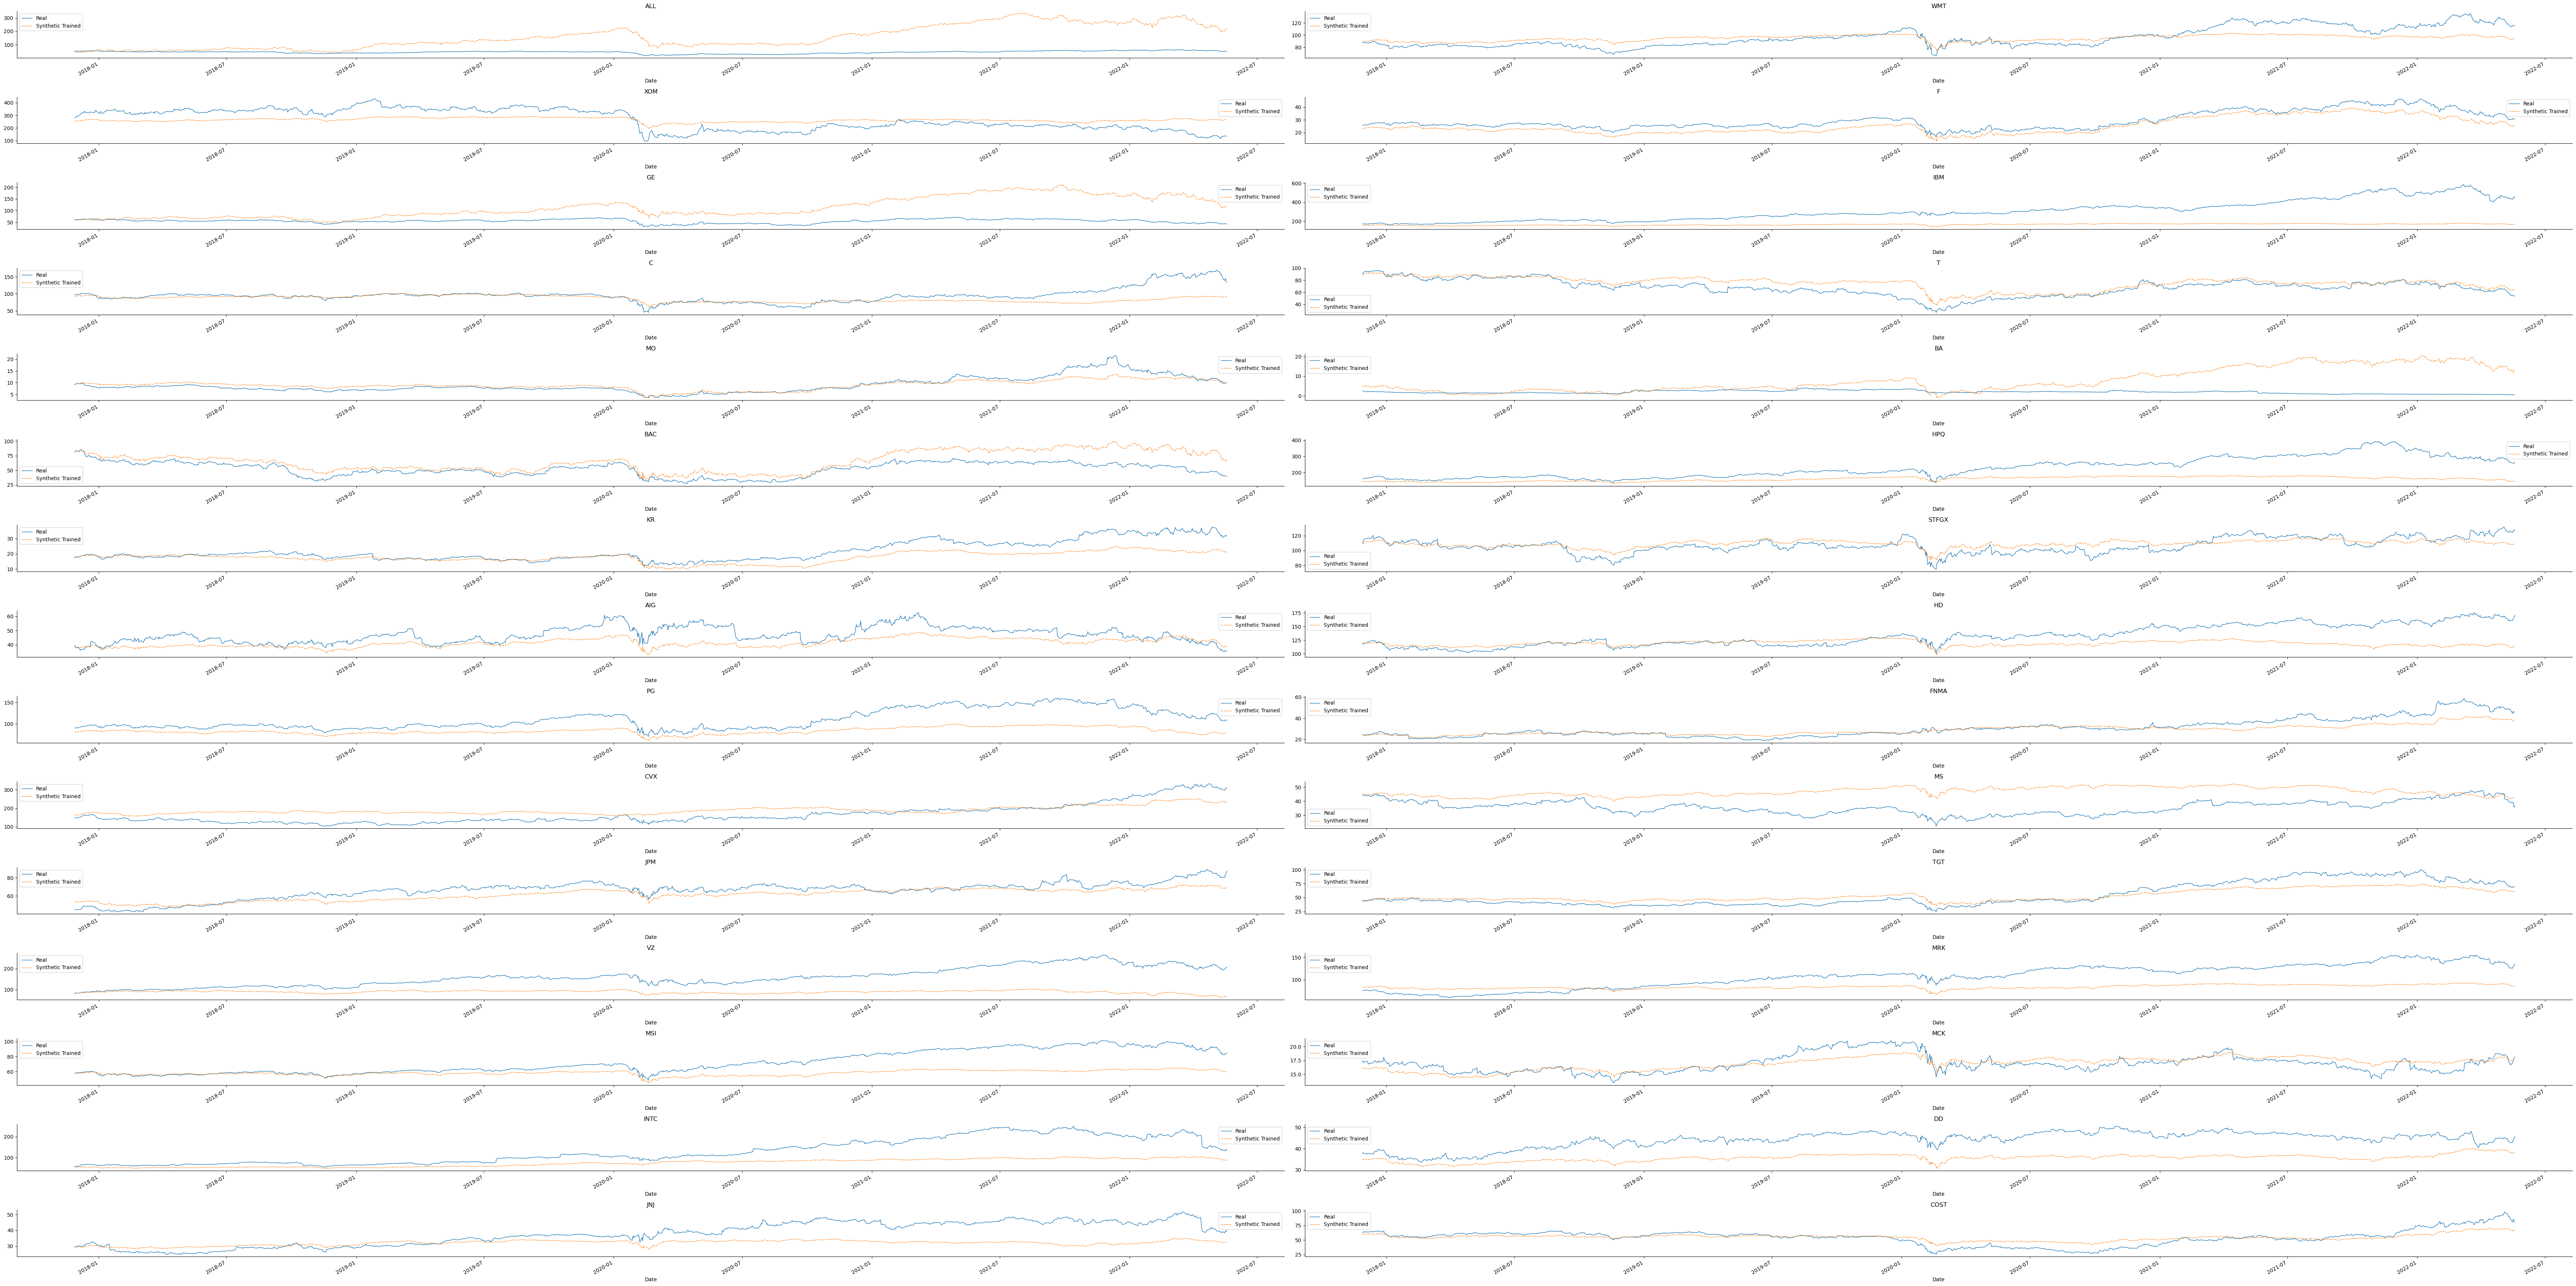

In [30]:
plot_preformance(real_unscaled, best_real_test_predict, log_dir / "real_prediction_plot")

In [31]:
stats_df = pd.concat(stats_dict, axis=1)
stats_df.to_csv(log_dir / 'real_out.csv', index=False)  

In [35]:
best_real_model[2]["IBM"].plot(filename=str(log_dir / "plot_ge_real.html"))

Row(id='3448', ...)

gio: file:///home/whd20002/time_gan_research_variable/experiment_00/plot_ge_real.html: Failed to find default application for content type ‘text/html’


In [36]:
best_real_return_avg

14.332089215823165

# Synthetic Looping

In [37]:
best_syn_model = None
best_syn_return_avg = 0
best_syn_test_predict = None
for k in range(iterations):
    print("Iteration: "+str(k))
    generated_data = generate_data()

    test_predict2 = model_predictions(generated_data, train_idx)
    test_predict2 = test_predict2.set_index(yf_index[test_idx])

    return_percents, stats_dict, bt_dict = backtest(test_predict2)
    return_avg = np.average(return_percents)

    if best_syn_model==None or best_syn_return_avg<return_avg:
        best_syn_model = return_percents, stats_dict, bt_dict
        best_syn_return_avg = return_avg
        best_syn_test_predict = test_predict2
        print("New Best With Returns: "+str(best_syn_model[0]))

Iteration: 0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-83.00591563613898, 25.226299166793815, -100.0, 133.47364099488252, -73.64276712738045, -31.781763217315657, -22.574517186584462, 24.860968663101158, 18.061621779708783, -78.86397020126354, 35.085058688163734, -100.0, -26.887307557334843, -33.13851912094116, -100.0, -24.374943963012665, -39.67729790863037, -68.15804342121953, 56.226135585784945, -100.0, 69.97098503204343, 145.76982181793215, 11.371545124740587, 22.273477713623052, -100.0, 140.06837507415776, 77.19372080528261, -47.15581195571899, -17.45547897491455, 132.0313552770996]
Iteration: 1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-88.9969360365296, -0.32569147567752227, -100.0, 11.222397688484198, -75.188134195633, -6.899671874694868, -32.82124067581173, -17.1226332750702, -27.398086834869417, -96.69196206542989, 77.62469418083194, 53.73507681678772, 69.16180911231997, -4.9185750871276825, -100.0, 19.456266730346687, 22.96242508941652, -74.47465096258286, 33.56160970169067, 91.29265212066649, -13.338954394988997, -45.648988297271735, 13.480266414413473, 7.3776176856994615, 11.071211682434095, 102.67604719238284, 36.99332062484741, 44.53919623229982, -17.994127952575692, -4.782839773559645]
Iteration: 2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-87.72336509918216, 0.07494059242248113, 458.90071958251957, 4.242203781261415, -45.93744246429443, 2.7759342626953183, -36.62369225204469, 30.405394251365653, -44.05763153503421, -96.36145715271, -100.0, -100.0, -45.552919526748646, -4.9185750871276825, 27.97184807525635, 21.286604925537123, -21.850596629028303, 91.68107466919551, 57.00847863983155, 69.09701199333198, -10.429373345489475, -43.50470813537597, 9.820014341201805, 13.561007278289816, 14.863823068847687, -100.0, -26.16940283157348, 19.657498034057625, 16.497163551330576, -44.264534951782224]
Iteration: 4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

New Best With Returns: [-43.66272779052729, -19.287423184967064, 164.62446333511352, 45.67479263441081, 133.08843409919737, -24.812409950408945, -28.27898505867003, -3.431727901992781, -54.03059976615905, -94.51758581893932, 7.1106533054351715, 49.97237052936553, -75.96514970909118, -20.736971000518796, 50.37598134193421, 23.061069440917965, -34.90643935134887, 533.9337518488907, -56.526658473663346, 89.97849401962284, 11.813739455566411, -20.019421472778333, 6.629945246658299, 14.227993994293229, 15.20540539489748, 90.25939125305176, 17.339273069686932, 19.18077623550416, 16.422141732788095, 48.26591740844728]
Iteration: 8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Iteration: 14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

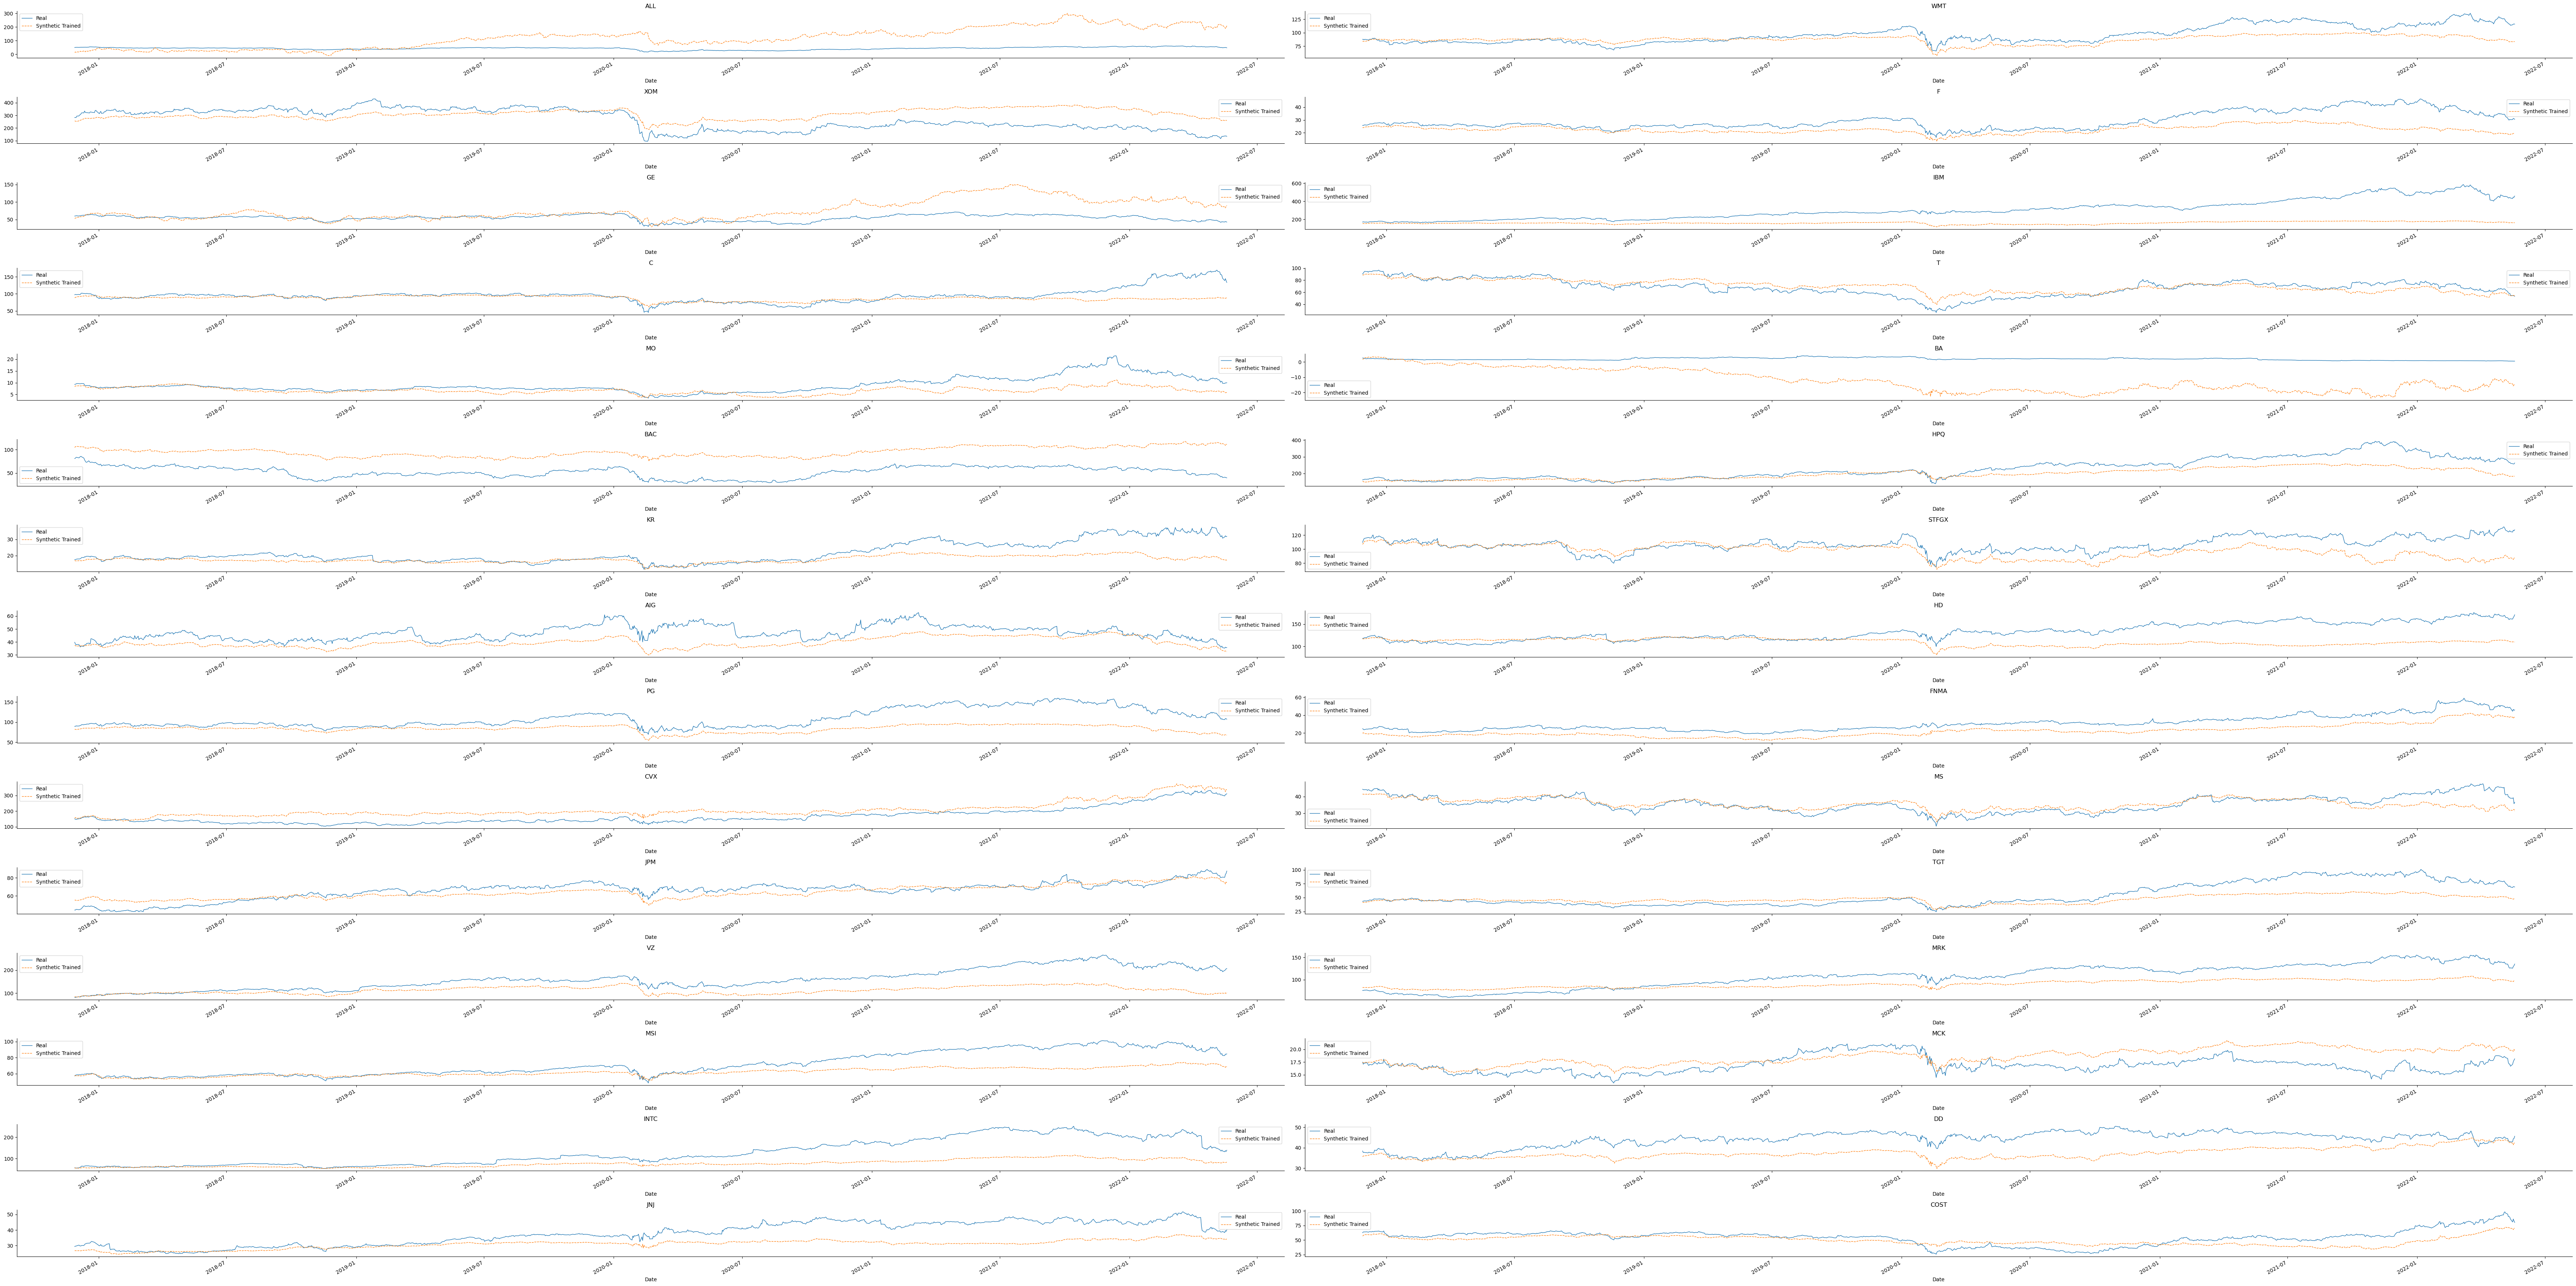

In [38]:
plot_preformance(real_unscaled, best_syn_test_predict, log_dir / "syn_prediction_plot")

In [39]:
stats_syn_df = pd.concat(best_syn_model[1], axis=1)
stats_syn_df.to_csv(log_dir / 'syn_out.csv', index=False)  

In [40]:
best_syn_model[2]["IBM"].plot(filename=str(log_dir / "plot_ge_syn.html"))

Row(id='4468', ...)

In [41]:
best_syn_return_avg

28.699616495557223

gio: file:///home/whd20002/time_gan_research_variable/experiment_00/plot_ge_syn.html: Failed to find default application for content type ‘text/html’
